# **Montar google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/

In [ ]:
import os

# **Variáveis com diretórios e nome de arquivos**

In [ ]:
CUSTOM_MODEL_NAME = 'my_mask_cnn' 
PRETRAINED_MODEL_NAME = 'mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

 files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

# **Criar diretórios**

In [ ]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}

# **Instalar object_detection do tensorflow**

In [ ]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [ ]:
# Instalar Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
 

In [ ]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Rodar testes para vefiricar a instalação
!python {VERIFICATION_SCRIPT}

In [ ]:
import object_detection

# **Download do modelo pré-treinado**

In [ ]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

# **Criar label map**

In [ ]:
labels = [{'name':'Whally', 'id':1}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# **Criar records**

In [ ]:
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}

In [ ]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

In [ ]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

# **Copiar configurações do modelo**

In [ ]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

# **Atualizar configurações**

In [ ]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [ ]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [ ]:
config

In [ ]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [ ]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [ ]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

In [ ]:
config_text

# **Treinar modelo**

In [ ]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [ ]:
print(command)

In [ ]:
!{command}

# **Carregar modelo**

In [ ]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [ ]:
# Carregar configs e construir modelo
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Carregar checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# **Detecção**

In [ ]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])


A = (326, 355)
B = (754, 355)
C = (754, 640)
D = (326, 640)

Centroid = (540, 497)



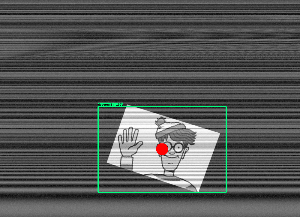

In [36]:
import os
from IPython.display import clear_output 
DIR = "/content/drive/MyDrive/Tensorflow/workspace/images/test/"
listCentroids = []

entries = [entry for entry in os.listdir(DIR)]
for nameImage in entries:

  clear_output()

  IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', nameImage)
  tf.config.experimental_run_functions_eagerly(True)
  img = cv2.imread(IMAGE_PATH)
  image_np = np.array(img)

  input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
  detections = detect_fn(input_tensor)

  num_detections = int(detections.pop('num_detections'))
  detections = {key: value[0, :num_detections].numpy()
                for key, value in detections.items()}
  detections['num_detections'] = num_detections

  #Convertendo detecção para int
  detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

  label_id_offset = 1
  image_np_with_detections = image_np.copy()

  viz_utils.visualize_boxes_and_labels_on_image_array(
              image_np_with_detections,
              detections['detection_boxes'],
              detections['detection_classes']+label_id_offset,
              detections['detection_scores'],
              category_index,
              use_normalized_coordinates=True,
              max_boxes_to_draw=5,
              min_score_thresh=.8,
              agnostic_mode=False)

  #Calcular centróides
  im_height, im_width, channels = img.shape
  (left, right, top, bottom) = (detections['detection_boxes'][0][1] * im_width, detections['detection_boxes'][0][3] * im_width, 
                                detections['detection_boxes'][0][0] * im_height, detections['detection_boxes'][0][2] * im_height)

  print("\nA = (" + str(int(left)) + ", " + str(int(top)) + ")")
  print("B = (" + str(int(right)) + ", " + str(int(top)) + ")")
  print("C = (" + str(int(right)) + ", " + str(int(bottom)) + ")")
  print("D = (" + str(int(left)) + ", " + str(int(bottom)) + ")")

  widthBox = int(right) - int(left)
  heightBox = int(bottom) - int(top)

  yCentroid = int((heightBox / 2) + int(top))
  xCentroid = int((widthBox / 2) + int(left))

  print("\nCentroid = (" + str(xCentroid) + ", " + str(yCentroid) + ")\n")

  image_np_with_detections = cv2.circle(image_np_with_detections, (xCentroid, yCentroid), radius=20, color=(0, 0, 255), thickness=-1)
  from google.colab.patches import cv2_imshow
  cv2_imshow(cv2.resize(image_np_with_detections, (0,0), fx=0.3, fy=0.3))

  #Salvar imagens
  DIR = "/content/drive/MyDrive/ImagesPredict/" + nameImage
  cv2.imwrite(DIR, image_np_with_detections)

  #Guardar centróides
  listCentroids.append(nameImage + "," + str(xCentroid) + "," + str(yCentroid) + "\n")

# **Salvar centróides**

In [ ]:
import os
import codecs

DIR = DIR = "/content/drive/MyDrive/"

with codecs.open("Centroids.txt", "w", encoding="utf8") as f:
  for c in listCentroids:
    f.write(c)
  f.close()

# **Download imagens com predição**

In [ ]:
!zip -r imagespredict.zip "/content/drive/MyDrive/ImagesPredict"

from google.colab import files
files.download("imagespredict.zip")

# **Download do modelo**

In [ ]:
!zip -r models.zip 'Tensorflow'

from google.colab import files
files.download("models.zip")